# Aprendizaje

## Atributos
- `hidden_layer_sizes`: Este modelo nos permite 2 capas de neuronas, los valores de esta tupla nos permiten especificar el número de neuronas en cada capa, debemos tener cuidado de que el número de neuronas no superen los datos y su dimensionalidad ya que en ese caso puede desembocar en overfitting.
- `activation`: La función de activación a usar, la forma de la función se verá reflejada en la decisión que puede tomar la neurona.
- `solver`: El algoritmo que controla como el modelo actualiza sus pesos internos.
- `learning_rate`: Como se modifica la tasa de aprendizaje respecto a los avances o falta de ellos obtenidos al procesar cada paquete de datos.

En este caso tenemos una frontera suave en la clasificación así que un modelo con una función de activación no lineal bien entrenada será capáz de clasificarla.

# Práctica

In [110]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

# 1. Genera una gran cantidad de puntos aleatorios (presión arterial y colesterol) y muestra los resultados en una gráfica, utilizando diferentes dibujos para cada punto.

In [ ]:
# Generamos los datos
instancias = 10000
# Presión arterial
min_pa = 70
max_pa = 180
umbral_pa = [100, 120]
min_cl = 120
max_cl = 250
umbral_cl = [180]
min_pm = 0
max_pm = 10000
umbral_pm = [9000]
pa = np.random.uniform(min_pa,max_pa, instancias)
cl = np.random.uniform(min_cl,max_cl, instancias)
peso_pa = 7
peso_cl = 5
# El riesgo añadido será 0 hasta sobrepasar el umbral
data = pd.DataFrame({'Presión Arterial': pa, 'Colesterol': cl})
def fun_risk_cl(cls, umbral_cl, min_cl, max_cl):
    risk = np.zeros_like(cls)
    for i, cl  in enumerate(cls):
        if cl < umbral_cl[0]:
            risk[i] = 0
        else:
            risk[i] = (cl - umbral_cl[0]) / (max_cl - umbral_cl[0])
    return risk

def fun_risk_pa(pas, umbral_pa, min_pa, max_pa):
    risk = np.zeros_like(pas)
    for i, pa in enumerate(pas):
        if pa < umbral_pa[0]:
            risk[i] = (umbral_pa[0] - pa) / (umbral_pa[0] - min_pa)
        elif umbral_pa[1] < pa:
            risk[i] = (pa - umbral_pa[1]) / (max_pa - umbral_pa[1])
        else:
            risk[i] = 0
    return risk

def fun_total_risk(risk_pa, risk_cl, peso_cl, peso_pa):
    return (risk_pa * peso_pa + risk_cl * peso_pa) / (peso_pa + peso_cl)

total_risk = fun_total_risk(
    fun_risk_cl(cl,umbral_cl, min_cl, max_cl),
    fun_risk_pa(pa, umbral_pa, min_pa, max_pa),
    peso_cl,
    peso_pa)
# We add some aleatory behaviour
te_toco = np.random.binomial(1, 1/100, instancias)
no_te_toco = np.random.binomial(1, 1/200, size=instancias)


def si_te_toco_te_toco(total_risk, te_toco, no_te_toco, umbral_riesgo):
    """
    Añadimos una función para incluir un factor de resistencia que evita el
    riesgo cardiaco en una persona aunque tenga parámetros de riesgo
    Y un factor de predisposición que genera riesgo cardiaco aunque la persona
    se situase normalmente fuera de riesgo.
    """
    in_risk = np.zeros_like(total_risk)
    for i, risk in enumerate(total_risk):
        if te_toco[i] == 1:
            in_risk[i] = 1
        elif no_te_toco[i] == 1:
            in_risk[i] = 0
        else:
            in_risk[i] = total_risk[i] > umbral_riesgo
    return in_risk
umbral_riesgo = 0.6
risk = si_te_toco_te_toco(total_risk, te_toco,no_te_toco, umbral_riesgo)
data['Risk'] = risk
sns.scatterplot(data, x='Presión Arterial', y = 'Colesterol', hue='Risk')

# 2. Divide el conjunto de datos en entrenamiento y evaluación como consideres.

In [ ]:
# Hacemos una separación del 75% para el entrenamiento
trainset, testset = train_test_split(data, test_size=0.25)

# 3. Entrena una red neuronal con el conjunto de entrenamiento.

In [241]:
model= MLPClassifier(
    learning_rate='adaptive',
    activation='logistic',
    hidden_layer_sizes=(50,40),
    solver='lbfgs',
    random_state=1234,
    max_iter=100)

model.fit(trainset[['Presión Arterial', 'Colesterol']], trainset['Risk'])

/home/paalcald/.virtualenvs/aiiot/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 40),
              learning_rate='adaptive', max_iter=100, random_state=1234,
              solver='lbfgs')

# 4. Aplica el modelo entrenado sobre el conjunto de evaluación.

In [ ]:
testset['Predicción'] = model.predict(testset[['Presión Arterial', 'Colesterol']])

testset['Missed'] = (testset['Risk'] != testset['Predicción'])


# 5. Muestra los resultados aplicados sobre el conjunto de evaluación. Se puede mostrar una gráfica como la anterior: puntos (presión arterial y colesterol) y su clasificación con MLP pintado de diversa manera (e.g. “x” o círculos)

<Axes: xlabel='Presión Arterial', ylabel='Colesterol'>

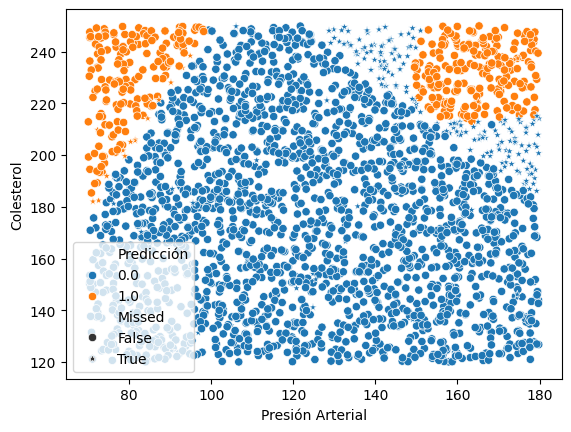

In [243]:
sns.scatterplot(testset, x='Presión Arterial', y = 'Colesterol', hue='Predicción', style='Missed', markers={ True: '*', False: 'o'})

# 6. Usa las métricas precisión y recall estudiadas en clase para evaluar la clasificación

In [244]:
true_positives = testset[(testset['Predicción'] == 1) & (testset['Risk'] == 1)]
false_negatives = testset[(testset["Risk"] == 0 ) & (testset['Predicción'] == 1)]
false_positives = testset[(testset['Predicción'] == 1) & (testset['Risk'] == 0)]

tp = len(true_positives)
fn = len(false_negatives)
fp = len(false_positives)

precision = 0 if (tp + fp) == 0 else tp / (tp + fp)
recall = 0 if (tp + fn) == 0 else tp / (tp + fn)

# 7. Para evitar “overfitting” habría que entrenar y validar los datos con conjuntos diferentes y con configuraciones de la red distintas. Prueba a mejorar la precisión de la red neuronal cambiando algunos de sus parámetros que has aprendido y haciendo distintas particiones del dataset. Se deben probar al menos dos configuraciones distintas.

In [245]:
# Utilizaremos Optuna para mejorar los hiperparametros.

def objective(test):
    solver = test.suggest_categorical(
        "solver", ['adam', 'lbfgs', 'sgd'])
    activation= test.suggest_categorical(
        "activation", ['tanh', 'identity', 'logistic', 'relu'])
    first_layer_n_neurons = test.suggest_int(
        'first_layer_n_neurons', 10, 50, step=5)
    second_layer_n_neurons = test.suggest_int(
        'second_layer_n_neurons', 10, 50, step=5)
    hidden_layer_sizes = (first_layer_n_neurons, second_layer_n_neurons)
    learning_rate = test.suggest_categorical(
        'learning_rate', ['constant', 'invscaling', 'adaptive'])

    model= MLPClassifier(
        learning_rate=learning_rate,
        activation=activation,
        hidden_layer_sizes=hidden_layer_sizes,
        solver=solver,
        random_state=1234,
        max_iter=100)

    model.fit(trainset[['Presión Arterial', 'Colesterol']], trainset['Risk'])
    y_pred = model.predict(testset[['Presión Arterial', 'Colesterol']])
    tp = len(testset[(y_pred == 1) &( testset['Risk'] == 1)])
    fn = len(testset[(testset["Risk"] == 0 ) & (y_pred != 0)])
    fp = len(testset[(y_pred == 1) &( testset['Risk'] == 0)])

    precision = 0 if (tp + fp) == 0 else tp / (tp + fp)
    recall = 0 if (tp + fn) == 0 else tp / (tp + fn)
    neuron_combinations = first_layer_n_neurons * second_layer_n_neurons

    return precision, recall, neuron_combinations

# 8. Calcula la precisión para cada una de las configuraciones realizadas en el punto anterior. Dibuja también sus gráficas.

In [246]:
study = optuna.create_study(directions=['maximize', 'maximize', 'minimize'])
study.optimize(objective, n_trials=100)

[I 2025-03-23 18:34:23,274] A new study created in memory with name: no-name-3cd07d17-507b-4b63-ab59-c2131c029237
[I 2025-03-23 18:34:23,784] Trial 0 finished with values: [0.0, 0.0, 1225.0] and parameters: {'solver': 'adam', 'activation': 'identity', 'first_layer_n_neurons': 35, 'second_layer_n_neurons': 35, 'learning_rate': 'adaptive'}.
/home/paalcald/.virtualenvs/aiiot/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-03-23 18:34:24,701] Trial 1 finished with values: [0.9705882352941176, 0.9705882352941176, 1250.0] and parameters: {'solver': 'sgd', 'activation': 'relu', 'first_layer_n_neurons': 50, 'second_layer_n_neurons': 25, 'learning_rate': 'constant'}.
/home/paalcald/.virtualenvs/aiiot/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to co

In [274]:
def convert_params(p):
    return {
        'solver': p['solver'],
        'activation': p['activation'],
        'hidden_layer_sizes': (p['first_layer_n_neurons'], p['second_layer_n_neurons']),
        'learning_rate': p['learning_rate'],
        'random_state' : 1234,
        'max_iter' : 100
    }

params_list = [convert_params(trial.params) for trial in study.best_trials]
params_list

[{'solver': 'lbfgs',
  'activation': 'tanh',
  'hidden_layer_sizes': (15, 30),
  'learning_rate': 'adaptive',
  'random_state': 1234,
  'max_iter': 100},
 {'solver': 'adam',
  'activation': 'tanh',
  'hidden_layer_sizes': (15, 35),
  'learning_rate': 'constant',
  'random_state': 1234,
  'max_iter': 100},
 {'solver': 'adam',
  'activation': 'tanh',
  'hidden_layer_sizes': (10, 10),
  'learning_rate': 'invscaling',
  'random_state': 1234,
  'max_iter': 100},
 {'solver': 'adam',
  'activation': 'relu',
  'hidden_layer_sizes': (20, 10),
  'learning_rate': 'adaptive',
  'random_state': 1234,
  'max_iter': 100},
 {'solver': 'sgd',
  'activation': 'identity',
  'hidden_layer_sizes': (25, 35),
  'learning_rate': 'invscaling',
  'random_state': 1234,
  'max_iter': 100},
 {'solver': 'adam',
  'activation': 'tanh',
  'hidden_layer_sizes': (25, 25),
  'learning_rate': 'adaptive',
  'random_state': 1234,
  'max_iter': 100}]

# 5. Entrena un regresor logístico (e.g. con clase LogisticRegression) con esos datos.

/home/paalcald/.virtualenvs/aiiot/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


<Axes: xlabel='Presión Arterial', ylabel='Colesterol'>

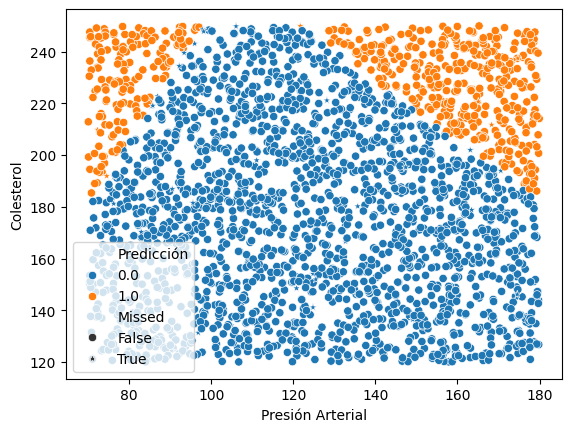

In [267]:
model = MLPClassifier(**params_list[0])
model.fit(trainset[['Presión Arterial', 'Colesterol']], trainset['Risk'])
testset['Predicción'] = model.predict(testset[['Presión Arterial', 'Colesterol']])
testset['Missed'] = (testset['Risk'] != testset['Predicción'])
sns.scatterplot(testset, x='Presión Arterial', y = 'Colesterol', hue='Predicción', style='Missed', markers={ True: '*', False: 'o'})


<Axes: xlabel='Presión Arterial', ylabel='Colesterol'>

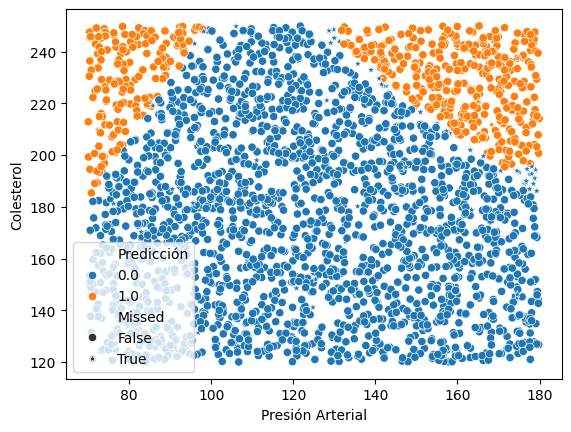

In [269]:
model = MLPClassifier(**params_list[1])
model.fit(trainset[['Presión Arterial', 'Colesterol']], trainset['Risk'])
testset['Predicción'] = model.predict(testset[['Presión Arterial', 'Colesterol']])
testset['Missed'] = (testset['Risk'] != testset['Predicción'])
sns.scatterplot(testset, x='Presión Arterial', y = 'Colesterol', hue='Predicción', style='Missed', markers={ True: '*', False: 'o'})

<Axes: xlabel='Presión Arterial', ylabel='Colesterol'>

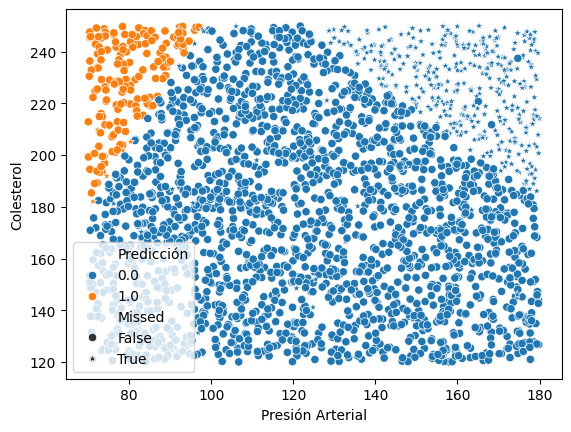

In [270]:
model = MLPClassifier(**params_list[2])
model.fit(trainset[['Presión Arterial', 'Colesterol']], trainset['Risk'])
testset['Predicción'] = model.predict(testset[['Presión Arterial', 'Colesterol']])
testset['Missed'] = (testset['Risk'] != testset['Predicción'])
sns.scatterplot(testset, x='Presión Arterial', y = 'Colesterol', hue='Predicción', style='Missed', markers={ True: '*', False: 'o'})

/home/paalcald/.virtualenvs/aiiot/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


<Axes: xlabel='Presión Arterial', ylabel='Colesterol'>

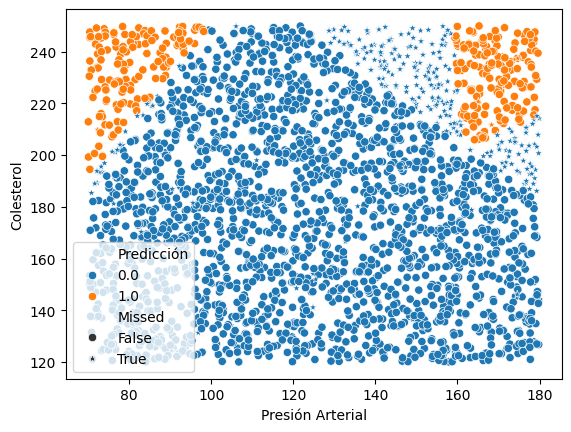

In [277]:
model = MLPClassifier(**params_list[3])
model.fit(trainset[['Presión Arterial', 'Colesterol']], trainset['Risk'])
testset['Predicción'] = model.predict(testset[['Presión Arterial', 'Colesterol']])
testset['Missed'] = (testset['Risk'] != testset['Predicción'])
sns.scatterplot(testset, x='Presión Arterial', y = 'Colesterol', hue='Predicción', style='Missed', markers={ True: '*', False: 'o'})

<Axes: xlabel='Presión Arterial', ylabel='Colesterol'>

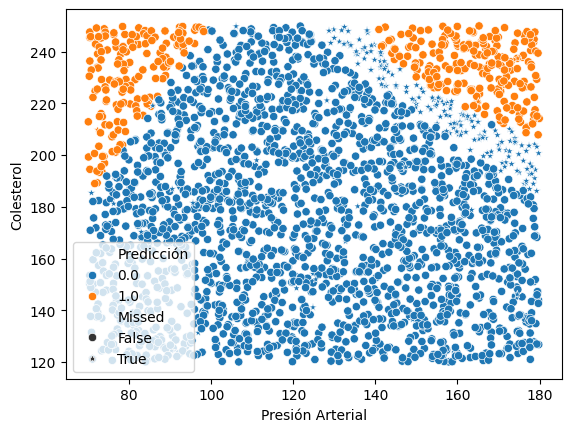

In [276]:
model = MLPClassifier(**params_list[5])
model.fit(trainset[['Presión Arterial', 'Colesterol']], trainset['Risk'])
testset['Predicción'] = model.predict(testset[['Presión Arterial', 'Colesterol']])
testset['Missed'] = (testset['Risk'] != testset['Predicción'])
sns.scatterplot(testset, x='Presión Arterial', y = 'Colesterol', hue='Predicción', style='Missed', markers={ True: '*', False: 'o'})

# 9. Discute los resultados y determina cuál es la mejor configuración de todas las estudiadas.
Hemos tratado de minimizar el número de capas para evitar overfitting al mismo tiempo que buscabamos maximizar el recall y la precision.

De este modo conseguimos unos resultados muy buenos con los siguientes parámetros

In [278]:
params_list[0]

{'solver': 'lbfgs',
 'activation': 'tanh',
 'hidden_layer_sizes': (15, 30),
 'learning_rate': 'adaptive',
 'random_state': 1234,
 'max_iter': 100}

El uso de la tangente hiperbólica nos permite que la función de activación segrege mejor los datos.

Que el el aprendizaje sea adaptativo nos permite que el componente de backpropagation se adapte mejor a nuestros valores.